<a href="https://colab.research.google.com/github/mlr2dev/machine_learning_refined_q1_2023_dev/blob/j_branch/notes/11_Feature_learning/11_10_Kfolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

# 11.10 K-Fold Cross-Validation

In this Section we detail a twist on the notion of ensembling called K-fold cross-validation, that is often applied when human interpret-ability of a final model is of significant importance.  While ensembling often provides a better fitting averaged predictor that avoids the potential pitfalls of any individual cross-validated model, *human interpret-ability* is typically lost as the final model is an average of many potentially very different nonlinearities (stumps / tree-based approximators are sometimes an exception to this general rule, as detailed in Section 14.1).  Instead of *averaging* a set of cross-validated models over many splits of the data, each of which provides minimum validation error over a respective split, with K-folds cross-validation we choose a single model that has minimum *average validation error* over all splits of the data.  This produces a potentially less accurate final model, but one that is significantly simpler (than an ensembled model) and can be more easily understood by humans.  As we will see, in special applications K-folds is also used with *linear* models as well.

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone images
    if not Path('chapter_11_images').is_dir():
        !ghclone https://github.com/mlr2dev/machine_learning_refined_q1_2023_dev/tree/j_branch/notes/11_Feature_learning/chapter_11_images
    else:
        print('chapter_11_images already cloned!')

# image paths
image_path_1 = "chapter_11_images/Figure_11_52.png"
image_path_2 = "chapter_11_images/Figure_11_53.png"
image_path_3 = "chapter_11_images/Figure_11_54.png"
image_path_4 = "chapter_11_images/Figure_11_55.png"

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## The K-Folds cross-validation procedure

*K-folds cross-validation* is a method for determining robust cross-validated models via an ensembling-like procedure that constrains the complexity of the final model so that it is more human-interpretable.  Instead of averaging a group of cross-validated models, each of which achieves a minimum validation over over a random training-validation split of the data, with K-folds cross-validation we choose a single final model that achieves the *lowest average validation error* over all of the splits together.  By selecting a \emph{single model} to represent the entire dataset, as opposed to an *average* of different models as is done with ensembling, we make it easier to human-interpret the selected model.

Of course the desire for any nonlinear model to be interpretable means that its fundamental building blocks (universal approximators of a certain type) need to be interpretable as well.  Neural networks, for
example, are almost never human interpretable while fixed-shape (most commonly polynomials) and tree-based approximators (commonly stumps) can be interpreted depending on the problem at hand.  Thus the latter two
types of universal approximators are more commonly employed with the K-folds technique.

To further simplify the final outcome of this procedure instead of using completely random training-validation splits, as done with ensembling, we split the data randomly into a set of $K$ non-overlapping pieces.  This is depicted visually in [Figure 11.52](#figure-11-52), where the original data is represented as the entire circular mass (top left panel) is split into $K=3$ non-overlapping sets (bottom row).  We then cycle through $K$ training-validation splits of the data that consist of $K-1$ of these pieces as training, with the final portion as validation, which allows for each point in the dataset to belong to a validation set precisely one time.  Each such split is referred to as a *fold*, of which there are $K$ in total, hence the name 'K-folds.'  On each fold we cross-validate the *same set of models* and record the validation score of each.  Afterwards we choose the single best model that produced the lowest *average validation error*.  Once this is done the minimum average validation model is re-trained over the entire dataset to provide a final tuned predictor of the data.  

---

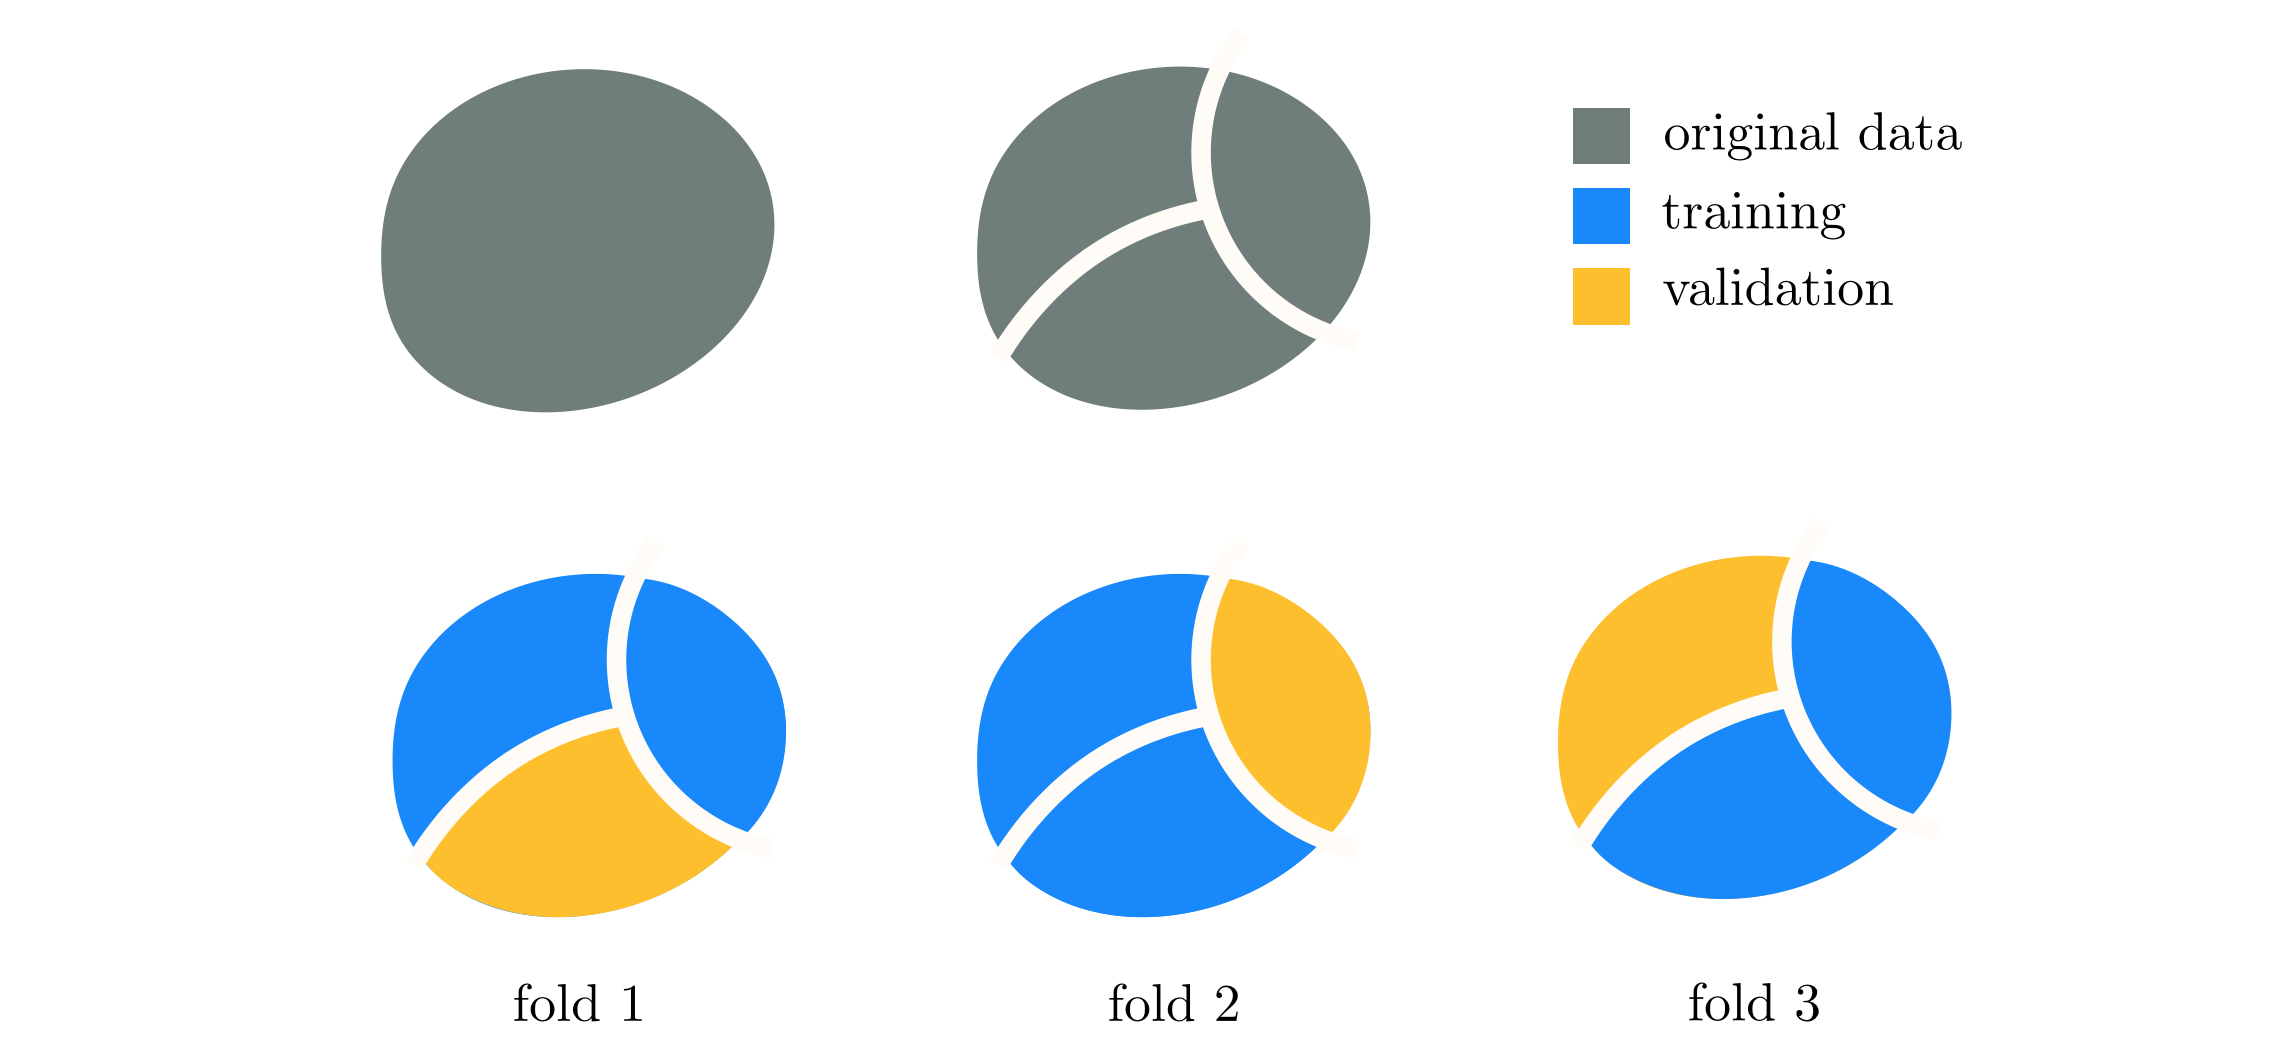

In [ ]:
Image(image_path_1)

<a id='figure-11-52'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.52 </strong> <em> 
Schematic illustration of K-folds cross-validation for
$K=3$.  The original data shown here as the entire circular mass (top
left) is split into $K$ non-overlapping sets.  Each of these sets is
referred to as a fold, and in each instance we keep a different
portion of the split data validation while merging the remaining $K-1$
pieces as training.  We perform cross-validation with the same set
of models on each of the $K$ folds (bottom), afterwards choosing the
single model with the lowest *average* validation error over all folds, with this model then re-trained over the entire original dataset to provide the final tuned predictor.
</em>
</figcaption>
</figure>

---

Since no models are combined / averaged together with K-folds, it can very easily produce less accurate models (in terms of *testing error* - see Section 11.7) for general learning problems when compared to ensembling.  However, when human interpret-ability of a model overshadows the needs for exceptional performance, K-folds produces a stronger performing model than a single cross-validated model that can still be understood by human beings.  This is somewhat analogous to the story of feature selection detailed in Sections [11.5](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_5_Boosting.html) and [11.6](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_6_Regularization.html), where human interpret-ability is the guiding motivator (and not simply model effectiveness).  In fact the notion of feature selection and K-folds cross-validation indeed intersect in certain applications, one of which we will see in the Examples below.

---

#### <span style="color:#a50e3e;">Example 11.19:</span>   Galileo's gravity experiment

In this Example we use K-folds cross-validation on the Galileo dataset detailed in Example 3 of [Section 10.2](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_2_Regression.html)  to recover the quadratic rule that was both engineered there, and that Galileo himself divined from a similar dataset. In the left column of [Figure 11.53](#figure-1153) we show how using $K=P$ fold cross-validation (since we have only $P=6$ data points intuition suggests, that we use a large value for $K$ as described in [Section 11.4](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_4_Cross_validation.html)), sometimes referred to as *leave-one-out K-folds cross -validation*, allows us to recover precisely the quadratic fit Galileo made by eye.  Note that by choosing $K=P$ this means that every data point will take a turn being the testing set.  Here we search over the polynomial models of degree $M=1,...,6$ since they are not only interpretable, but are appropriate for data gleaned from physical experiments (which often trace out smooth rules).  While not all of the models over the $6$ folds fit the data well, the average K-folds result is indeed the $M^{\star}=2$ quadratic polynomial fit originally proposed by Galileo.

---

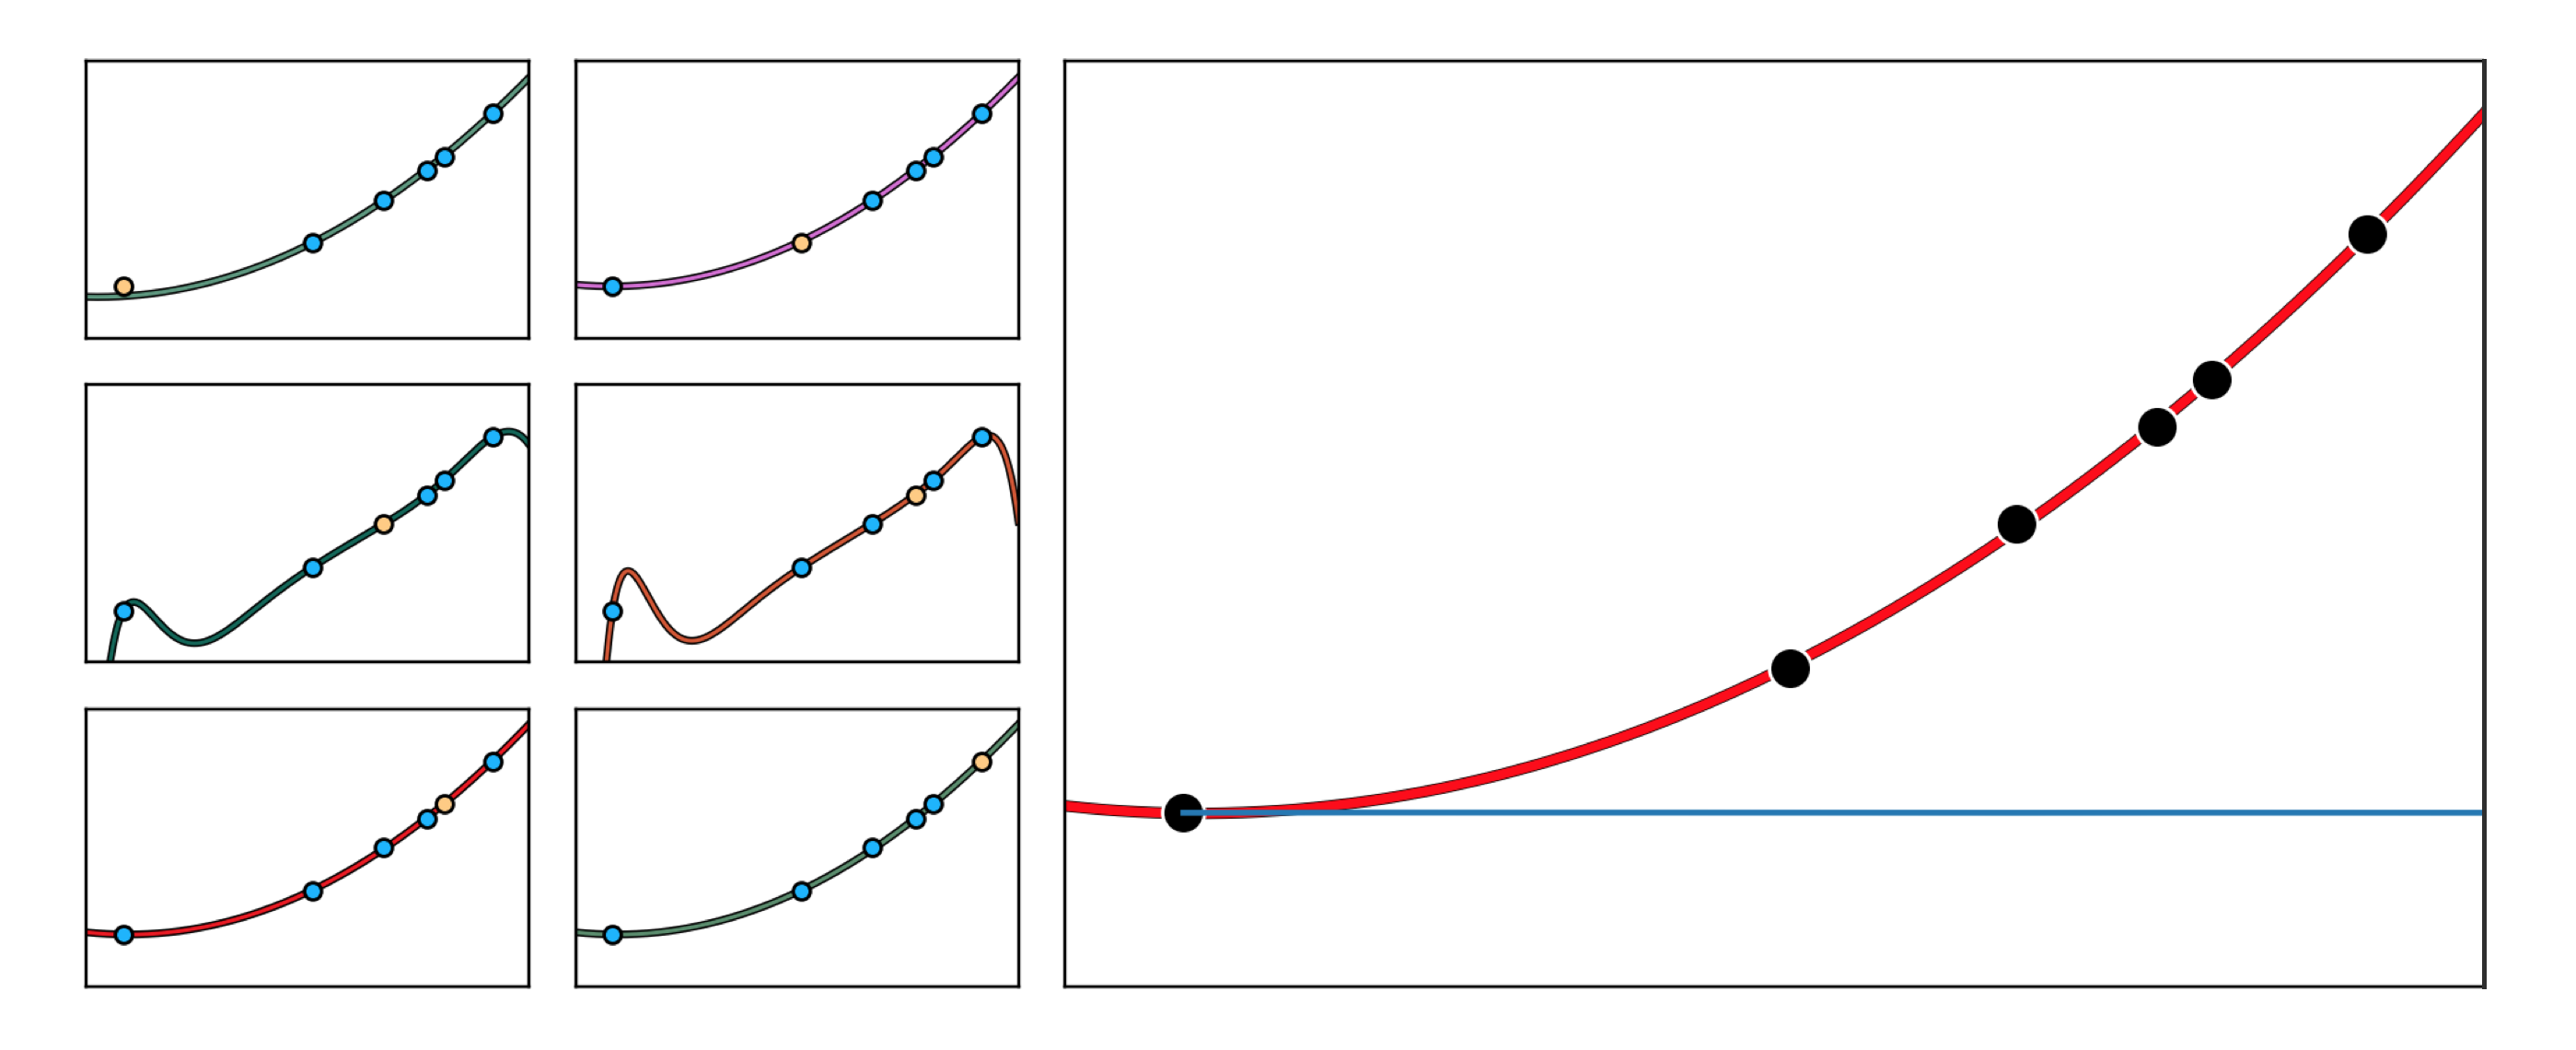

In [ ]:
Image(image_path_2)

<a id='figure-11-53'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.53 </strong> <em> 
left column) The resulting $K=6$ cross-validated models, each trained on all but one point from the dataset (here the validation portion of each fold is highlighted in yellow).  (right panel) The K-fold average validation error minimizing model, a quadratic, shown in red.  See text for further details
</em>
</figcaption>
</figure>

---

##  K-folds and high dimensional linear modeling

Suppose for a moment we have a high capacity model which enables several kinds of overfitting behavior for a nonlinear regression dataset, with each overfitting instance of the model provided by different settings of the linear combination weights of the model (suppose any internal parameters of its features are fixed).  We illustrate such a scenario in the left panel of [Figure 11.54](#figure-11-54), where two settings of such a model provide two distinct overfitting predictors for a generic nonlinear regression dataset.  As we learned in [Section 10.2](https://jermwatt.github.io/machine_learning_refined/notes/10_Nonlinear_intro/10_2_Regression.html), any *nonlinear model* in the original space of a regression dataset corresponds to a \emph{linear model} in the transformed feature space (i.e., the space where each individual input axis is given by one of the chosen nonlinear feature).  Since our model easily overfits the original data, in the transformed feature space our data lies along a *linear subspace* that can be perfectly fit using many different hyperplanes.  Indeed the two nonlinear overfitting models shown in the left panel of the Figure  correspond one-to-one with the two linear fits in the transformed feature space - here illustrated symbolically in the right panel of the Figure (in reality we could not visualize this space, as it would likely be too high dimensional).  In other words, a severely overfitting high capacity \emph{nonlinear model} in the original regression space is severely overfitting high capacity *linear model* in the transformed feature space feature.  This fact holds regardless of the problem type.

---

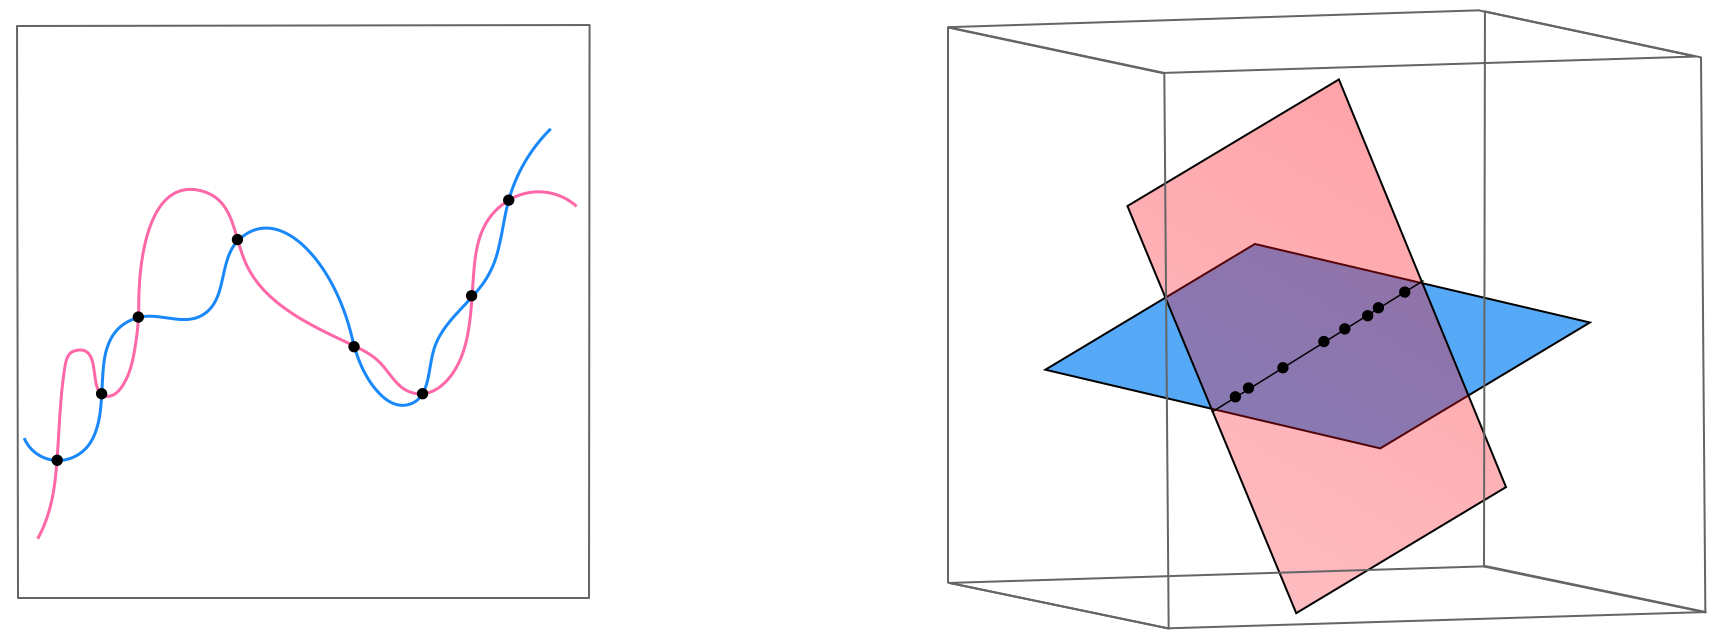

In [ ]:
Image(image_path_3)

<a id='figure-11-54'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.54 </strong> <em> 
(left panel) Two instances of overfitting by a high capacity model to a nonlinear regression dataset.  (right panel) These two models - as viewed in the \emph{feature transformed space} - are linear.  See text for further details.
</em>
</figcaption>
</figure>

---

The general scenario detailed in the right panel of [Figure 11.54](#figure-11-54) is precisely where we begin when faced with small datasets that have very high input dimension: in such scenarios \emph{even a linear model has extremely high capacity and can easily overfit}, virtually ruling out the use of more complicated nonlinear models.  Thus in such scenarios, in order to properly tune the parameters of a high capacity (linear) model we often turn to the cross-validation technique designed specifically to block high capacity models: *regularizer-based* regularization (as described in [Section 11.6](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_6_Regularization.html)).  Given the small amount of data at play to determine the best setting of the regularization parameter K-folds is commonly employed to determine the proper regluarization parameter value and ultimately the parameters of the linear model.

This scenario often provides an interesting point of intersection with the notion of *feature selection via regularization* detailed in [Section 9.7](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_7_Regularization.html).  Employing the $\ell_1$ regularizer we can block the capacity of our high capacity linear model *while simultaneously* selecting important input features, making human interpret-ability possible.

---

#### <span style="color:#a50e3e;">Example 11.20:</span>   Genome-wide association studies

Genome-wide association studies (GWAS) aim at understanding the connections between tens of thousands of genetic markers, taken from across the human genome of several subjects, with diseases like high blood pressure and cholesterol, heart disease, diabetes, various forms of cancer, and many others. These studies typically produce small datasets of high dimensional (input) genetic information taken from a sample of patients with a given affliction and a control group of non-afflicted (see [Figure 11.55](#figure-11-55)). Thus regularization based cross-validation a useful tool for learning meaningful (linear) models for such data. Moreover using a feature selecting regularizer like the $\ell_1$ norm can help researchers identify the handful of genes critical to affliction, which can both improve our understanding of disease and perhaps provoke development of gene-targeted therapies. 

---

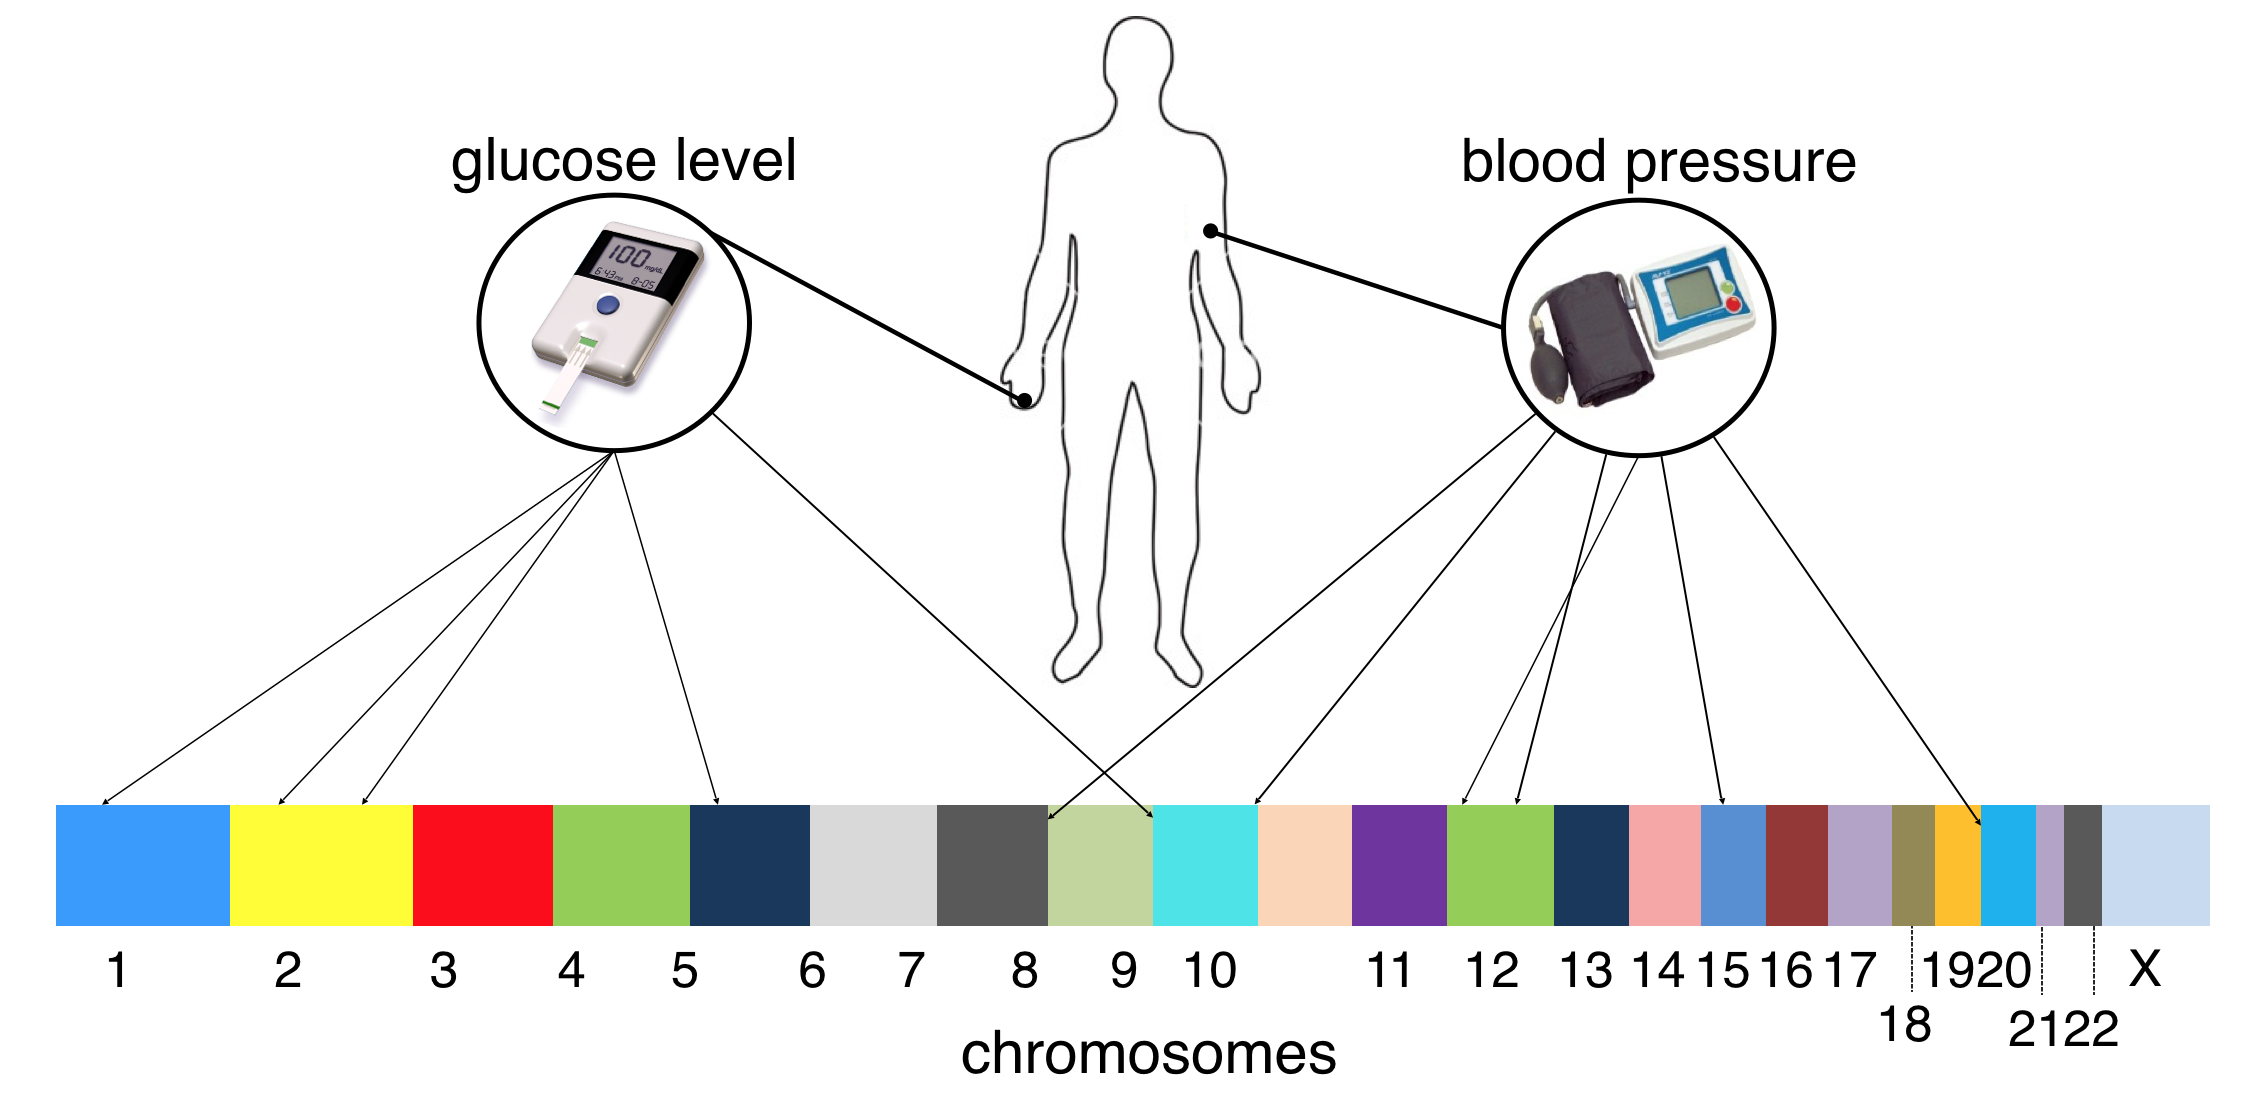

In [ ]:
Image(image_path_4)

<a id='figure-11-55'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.55 </strong> <em> 
Figure associated with Example 11.20. See text for details. 
</em>
</figcaption>
</figure>

---